In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn
import random
import importlib
resources = importlib.import_module("resources")
import resources.finiteMDP as fmdp
import resources.infMDP as imdp
from itertools import product
random.seed(100)

%matplotlib inline



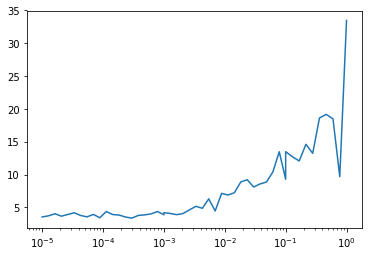

In [2]:
# GridWorld

states = list(range(22)) ; states.append('inf')
actions = ["AU","AD","AL","AR"]
action_dict= {"AU":[.8,0,.05,.05,.1],
              "AL":[.05,.05,.8,0,.1],
              "AR":[.05,.05,0,.8,.1],
              "AD":[0,.8,.05,.05,.1]}
                #   U D L R C
transition_dict = {0:[0,5,0,1,0],
                   1:[0,5,-1,1,0],
                   2:[0,5,-1,1,0],
                   3:[0,5,-1,1,0],
                   4:[0,5,-1,0,0],
                   5:[-5,5,0,1,0],
                   6:[-5,5,-1,1,0],
                   7:[-5,0,-1,1,0],
                   8:[-5,4,-1,1,0],
                   9:[-5,4,-1,0,0],
                  10:[-5,4,0,1,0],
                  11:[-5,4,-1,0,0],
                  12:[-4,4,0,1,0],
                  13:[-4,4,-1,0,0],
                  14:[-4,4,0,1,0],
                  15:[-4,4,-1,0,0],
                  16:[-4,5,0,1,0],
                  17:[-4,None,-1,0,0],
                  18:[-4,0,0,1,0],
                  19:[-4,0,-1,1,0],
                  20:[0,0,-1,1,0],
                  21:[-5,0,-1,None,0]}
def transition_func(state,action):
    direction = np.random.choice(list(range(5)),p = action_dict[action])
    change = transition_dict[state][direction]
    if change is None:
        return 'inf'
    else:
        return state + change
def reward_func(state,action):
    if state ==20:
        return -10
    elif state == 'inf':
        return 10
    else:
        return 0
def policy_random(state,actions):
    return random.choice(actions)
myMDP = fmdp.MDP(states,actions,transition_func,reward_func,lambda : 0, .9, policy_random)

episodes = 100
x_range = np.concatenate((np.logspace(-5,-3,20),np.logspace(-3,-1,20),np.logspace(-1,0,10)))
y = []
for alpha in x_range:
    V_pi = fmdp.TemporalDifference(episodes,alpha,myMDP)
    y.append(fmdp.TestTD(episodes,alpha,myMDP,V_pi))
plt.xscale('log')
plt.plot(x_range,y)

#alpha=  .1
#V_pi = fmdp.TemporalDifference(100,alpha,myMDP)
#print(fmdp.TestTD(100,alpha,myMDP,V_pi))



In [2]:
# CartPole
actions = ("L","R")
def policy_random(state,actions):
    return random.choice(actions)


max_angle = math.pi/2
min_angle = -math.pi/2
max_t = int(20.2/.02)
max_x = 3
min_x = -3
def termination_func(state,time):
    vel,pos,ang_vel,theta = state    
    return (pos > max_x or pos<min_x or theta<min_angle or theta>max_angle or time >= max_t) 
def reward_func(state,action):
    if termination_func(state,0):
        return 0
    else:
        return 1
    
delta_t = .02
m_p = .1
m_c = 1
mcp = m_c+m_p
l = .5
motor_force = 10 #in newtons
g = 9.8

def transition_func(state,action):
    vel,pos,ang_vel,theta = state
    sin = math.sin(theta)
    cos = math.cos(theta)
    if action == 'L':
        F = -motor_force
    else:
        F = motor_force
    x = (F + l*m_p*sin*(ang_vel**2))/mcp
    ang_acc = (g*sin-cos*x)/(l*(4/3-m_p*cos**2/mcp))
    #    acc = (F+m_p*l*(sin*ang_vel**2-ang_acc*cos))/mcp
    acc = x - l*m_p*ang_acc*cos/mcp

    pos += vel*delta_t
    theta += ang_vel*delta_t
    vel += acc*delta_t
    ang_vel += ang_acc*delta_t
    return (vel,pos,ang_vel,theta)

n = 3 # 5 or 3
d = 4  
basis_matrix = np.array(list(product(range(n+1),repeat = d)),dtype=np.float64)
state_normalized = np.zeros(4,dtype=np.float64)
max_v = 10; min_v = -10
max_a = np.pi ; min_a = -np.pi
epsilon = 10
wide_max_x = max_x+epsilon ; wide_min_x = min_x-epsilon
wide_max_theta = max_angle+epsilon; wide_min_theta = min_angle-epsilon

def normalize_basis(state):
    global state_normalized
    state_normalized[0] = (state[0]-min_v)/(max_v-min_v)    
    state_normalized[1] = (state[1]-wide_min_x)/(wide_max_x-wide_min_x)
    state_normalized[2] = (state[2]-min_a)/(max_a-min_a)    
    state_normalized[3] = (state[3]-wide_min_theta)/(wide_max_theta-wide_min_theta)

def fourier_basis(state):
    normalize_basis(state)
    return np.cos(np.pi*np.dot(basis_matrix,state_normalized))

myMDP = imdp.infinite_state_MDP(actions,transition_func,reward_func,termination_func\
                                ,lambda : (0,0,0,0), 1, policy_random)

episodes = 100
no_dim = (n+1)**d
x_range = np.concatenate((np.logspace(-5,-3,20),np.logspace(-3,-1,20)))
y = []
np.seterr(all='raise')
for alpha in x_range:
    try:
        w = imdp.TemporalDifferenceParameters(no_dim,fourier_basis,imdp.delta_linear,imdp.linear_policy,episodes,alpha,myMDP)
        y.append(imdp.test_TDParameters(no_dim,fourier_basis,imdp.delta_linear,imdp.linear_policy,episodes,alpha,myMDP,w))
    except FloatingPointError:
        #print("!")
        y.append(0)
for i in range(len(y)):
    if np.isnan(y[i]) or y[i]>100: #If diverged, set to 0
        y[i] = 0
plt.xscale('log')
plt.plot(x_range,y)



(256,)
(256,)


AssertionError: 

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.xscale('log')
plt.plot(x_range, y)
plt.grid(True)
y


[0.9563224205370691,
 1.0214736724296056,
 1.0798769509795851,
 1.3202332913187322,
 1.671334596164132,
 2.197588747766005,
 2.0539436013995176,
 2.372881520678969,
 2.857620219658885,
 3.323787302252621,
 3.126719833537669,
 4.538776081524553,
 3.043575448252864,
 3.2423461220748435,
 3.505073656205383,
 3.333294857512224,
 2.163546448712526,
 1.4684717658399038,
 2.403272108011138,
 5.082729306355331,
 1.6384564924250018,
 6.6270322562393185,
 4.055197852194113,
 5.552423117251155,
 20.04497118697408,
 10.198723881735233,
 8.657692423240226,
 5.090624216799057,
 8.624537159418866,
 3.55859112689111e+42,
 2.4548676181508187e+241,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [6]:
from itertools import product

n = 3 # 5 or 3
d = 4  
basis_matrix = np.array(list(product(range(n+1),repeat = d)),dtype=np.float64)

import numpy as np
np.product(np.power([1,2],[[1,2],[3,4]]),axis=1)

array([ 4, 16], dtype=int32)

In [7]:
basis_matrix

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 2.],
       ...,
       [3., 3., 3., 1.],
       [3., 3., 3., 2.],
       [3., 3., 3., 3.]])